#**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

#**Curso: TC4034 - Análisis de grandes volúmenes de datos**

#Tecnológico de Monterrey

#**Semana 9**

#Avance de proyecto 4: Sistema de Recomendación

#**Equipo 20**

#   Zmaltzin Paola Godínez Juárez - A01794538

#   Julio César Mestas Delgado    - A01794827

## Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357251 sha256=f1a7d40b829d59e81c48acf8f28060afeb511a729db74671c62f003f256a2b1e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

## Paso 2: Cargando los datos

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [7]:
movies = pd.read_csv("/content/drive/MyDrive/Documentos/Tec de Monterrey/MNA/BIG DATA/SEMANA 10/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Documentos/Tec de Monterrey/MNA/BIG DATA/SEMANA 10/Netflix_Dataset_Rating.csv")

In [8]:
netflix = ratings.merge(movies[['Movie_ID', 'Title', 'Year']])
netflix.head()

,User_ID,Rating,Movie_ID,Title,Year
0,712664,5,3,Character,1997
1,1331154,4,3,Character,1997
2,2632461,3,3,Character,1997
3,44937,5,3,Character,1997
4,656399,4,3,Character,1997


Podemos ver que el dataset cuenta con el id de la pelicula, el titulo, el identificador del usuario, el rating y el año

## Paso 3: Exploracion de los Datos



#### Calculemos cuantos generos de peliculas contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada genero en el dataset.

In [9]:
from collections import Counter

contador_peliculas = Counter(title for title in netflix['Title'])
print(f"Existen {len(contador_peliculas)} nombres de películas.")

Existen 1342 nombres de películas.


Existen 1342 diferentes títulos de peliculas.


#### Cuales son las peliculas mas comunes?

Utilizaremos el metodo mas comun de `Counter` que es `most_common()` para obtener el listado de generos con asociados a la mayor cantidad de peliculas.

In [10]:
print("Top 10 de peliculas: \n", contador_peliculas.most_common(10))

Top 10 de peliculas: 
 [('Pirates of the Caribbean: The Curse of the Black Pearl', 117075), ('Lord of the Rings: The Fellowship of the Ring', 102721), ('The Sixth Sense', 102376), ('American Beauty', 101450), ('Bruce Almighty', 98545), ('The Silence of the Lambs', 95053), ('Finding Nemo (Widescreen)', 94235), ('The Italian Job', 93886), ('Shrek 2', 92893), ('Braveheart', 91502)]


En el Top 5 de peliculas encontramos: `Pirates of the Caribbean: The Curse of the Black Pearl`, `Lord of the Rings: The Fellowship of the Ring`, `The Sixth Sense', 102376`, `American Beauty`, `Bruce Almighty`, `The Silence of the Lambs`, `Finding Nemo (Widescreen)`, `The Italian Job`, `Shrek 2`, `Braveheart`.

Utilizemos barplot para visualizar parte de esta informacion.

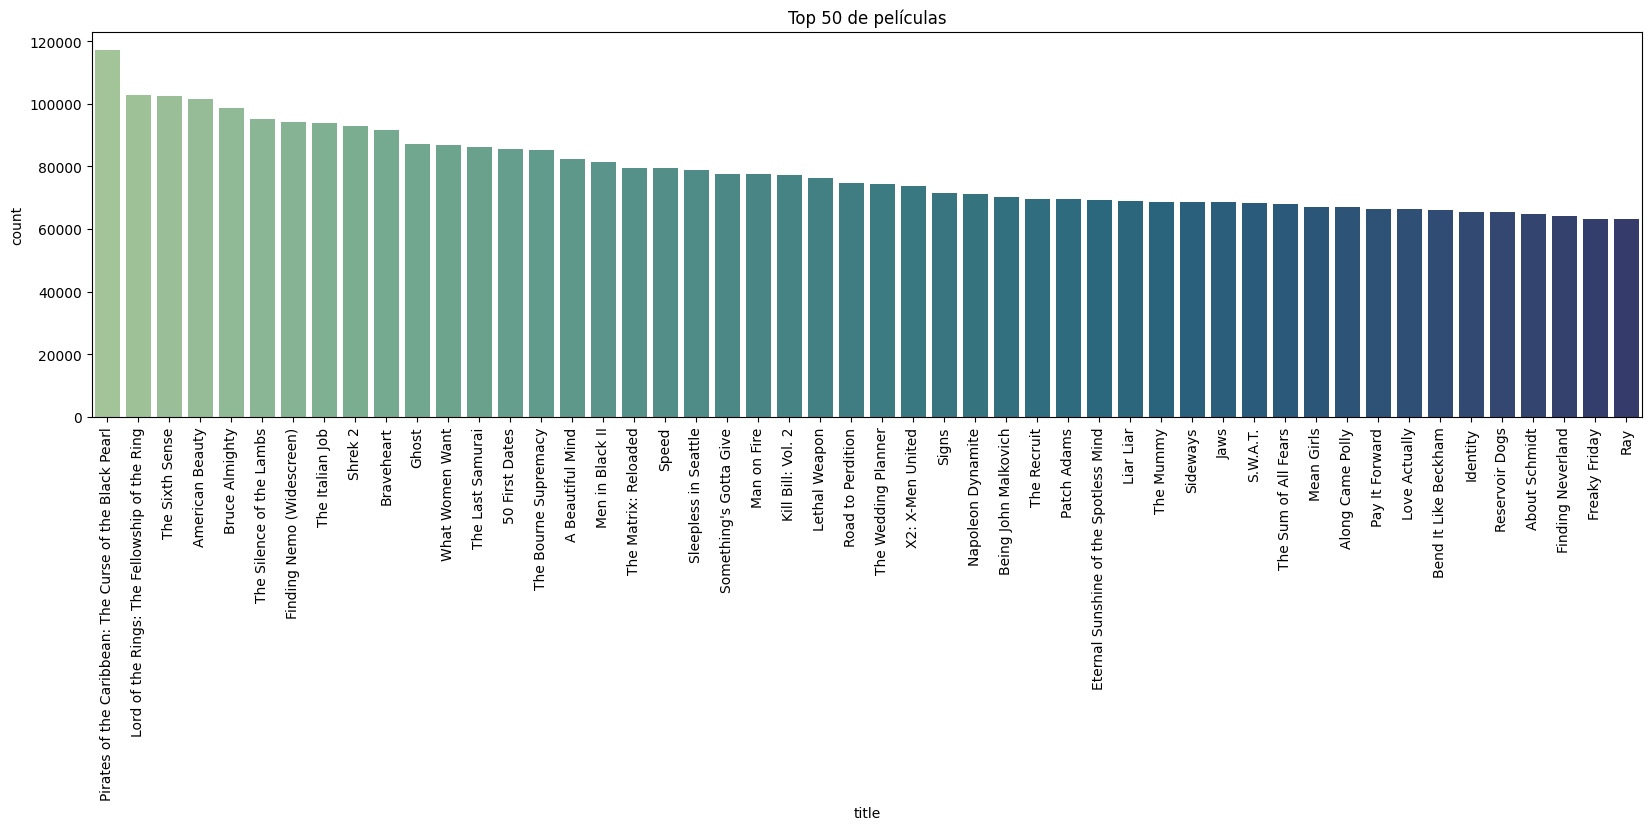

In [11]:
movie_counts_df = pd.DataFrame([contador_peliculas]).T.reset_index()
movie_counts_df.columns = ['title', 'count']
movie_counts_df = movie_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='title', y='count', data=movie_counts_df[:50], palette='crest')
plt.xticks(rotation=90)
plt.title(f"Top 50 de películas")
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, `Pirates of the Caribbean: The Curse of the Black Pearl`, `Lord of the Rings: The Fellowship of the Ring`, `The Sixth Sense` son las 3 peliculas con mas vistas.

#### Cuantos año distintos estan contenidos en nuestro dataset?


In [12]:
unique_years = netflix['Year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 73


Con este calculo rapido, nos percatamos que contamos con mas de 73 años en nuestro dataset.

## Paso 4: Transformando los datos

Primeramente se creará una matriz con el identificador del usuario, el título de la película y los ratings:


In [13]:
df_p = pd.pivot_table(netflix, values="Rating", index="User_ID", columns="Title")
df_p

Title,10,10 Things I Hate About You,101 Dalmatians II: Patch's London Adventure,11:14,13 Ghosts,18 Again,1984,2 Fast 2 Furious,200 Cigarettes,2010: The Year We Make Contact,...,Xena: Warrior Princess: Season 3,Xena: Warrior Princess: Series Finale,Y Tu Mama Tambien,Yellow Submarine,Yi Yi,Yojimbo,Young Black Stallion,Youngblood,Yu-Gi-Oh!: The Movie,Zorro
User_ID,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2649378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Paso 5: Determinar el usuario objetivo

El usuario objetivo se selecciona aleatoriamente mediante la siguiente expresión:

In [14]:
User_target = int(pd.Series(df_p.index).sample(1).values)
print("Usuario Objetivo:", User_target)

Usuario Objetivo: 1097757


En la siguiente sección se evalua lo que en el pasado el usuario target califico positivamente:

In [15]:
df_user_target = netflix[(netflix["User_ID"] == User_target) & (netflix["Rating"] == 5)]
df_user_target = df_user_target.set_index("Movie_ID")
df_user_target.head()

,User_ID,Rating,Title,Year
Movie_ID,,,,
118,1097757,5,Rambo: First Blood Part II,1985
143,1097757,5,The Game,1997
197,1097757,5,Taking Lives,2004
209,1097757,5,Star Trek: Deep Space Nine: Season 5,1996
285,1097757,5,The Devil's Own,1997


Posteriormente se determina el total de películas vistas por el usuario target:

In [16]:
user_df = df_p[df_p.index == User_target]
movies_watched = user_df.columns[user_df.notna().any()].tolist()
print("Número de películas vistas por el usuario seleccionado aleatoriamente:", len(movies_watched))
print("Ejemplos de películas vistas por este usuario seleccionado:")
movies_watched[:20]

Número de películas vistas por el usuario seleccionado aleatoriamente: 118
Ejemplos de películas vistas por este usuario seleccionado:


['28 Days Later',
 'A Beautiful Mind',
 'A Nightmare on Elm Street',
 'Absolute Power',
 "Alien: Collector's Edition",
 "Alien: Resurrection: Collector's Edition",
 "Aliens: Collector's Edition",
 'Armageddon',
 'Back to the Future Part III',
 'Bad Boys',
 'Bad Boys II',
 'Beverly Hills Cop',
 'Beverly Hills Cop III',
 'Blade: Trinity',
 'Braveheart',
 'Bruce Almighty',
 'Chain Reaction',
 'City by the Sea',
 'Clash of the Titans',
 'Cocoon']

## Paso 6: Construyendo un sistema de recomendacion de filtrado colaborativo utilizando Similitud Coseno - Algoritmo básico

El método de filtrado colaborativo se basa en recopilar y analizar información sobre los comportamientos de los usuarios, sus actividades o preferencias y predecir qué les gustará en función de la similitud con otros usuarios.

En este apartado se buscarán los usuarios similares al usuario seleccionado anteriormente de manera aleatoria para ofrecer peliculas basadas ​​en lo que usuarios similares han visto.

Para construir este sistema de recomendacion utilizaremos una metrica llamada similitud coseno `cosine similarity`.Utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

Primeramente identificaremos otros usuarios que han visto las mismas películas o al menos una de las películas que vio el usuario seleccionado:

In [17]:
movies_watched_df = df_p[movies_watched]
movies_watched_df.head()
print("Número de usuarios que han visto las mismas películas o al menos una de las películas que vio el usuario:", movies_watched_df.shape[0])

Número de usuarios que han visto las mismas películas o al menos una de las películas que vio el usuario: 143458


Ahora es importante determinar cuántas de estas películas vieron los otros usuarios:

In [18]:
users_movie_count = movies_watched_df.T.notnull().sum()
users_movie_count = users_movie_count.reset_index()
users_movie_count.columns = ['Movie', 'Count']
users_movie_count = users_movie_count.sort_values(by='Count', ascending=False)
print("Top 10 de usuarios que vieron el mayor número de películas vistas por el usuario objetivo:")
users_movie_count.head(10)

Top 10 de usuarios que vieron el mayor número de películas vistas por el usuario objetivo:


,Movie,Count
132092,2439493,118
21168,387418,118
59837,1097757,118
17486,322009,116
90366,1664010,116
16592,305344,116
71577,1314869,116
141109,2606799,115
114829,2118461,115
882,16272,114


Para reducir el número de opciones se eligen los usuarios que vieron al menos el 50% de las películas de nuestro usuario objetivo:


In [19]:
m_count = movies_watched_df.shape[1]
users_same_movies=users_movie_count[users_movie_count["Count"]/m_count > 0.50].sort_values("Count", ascending=False)
print("Número de usuarios que vieron al menos el 50% de las películas de nuestro usuario objetivo:", users_same_movies.shape[0])
print("Los 10 usuarios con el mayor número de coincidencias:")
users_same_movies[:10]

Número de usuarios que vieron al menos el 50% de las películas de nuestro usuario objetivo: 15542
Los 10 usuarios con el mayor número de coincidencias:


,Movie,Count
132092,2439493,118
21168,387418,118
59837,1097757,118
17486,322009,116
90366,1664010,116
16592,305344,116
71577,1314869,116
141109,2606799,115
114829,2118461,115
39086,716173,114


Finalmente se reunen los usuarios más similares al usuario objetivo en un pandas dataframe:

In [20]:
final_df = pd.concat([movies_watched_df[movies_watched_df.index.isin(users_same_movies.index)],
                      user_df[movies_watched]])

print("Tamaño del DataFrame final:", final_df.shape)
final_df.head(5)

Tamaño del DataFrame final: (797, 118)


Title,28 Days Later,A Beautiful Mind,A Nightmare on Elm Street,Absolute Power,Alien: Collector's Edition,Alien: Resurrection: Collector's Edition,Aliens: Collector's Edition,Armageddon,Back to the Future Part III,Bad Boys,...,The Tuskegee Airmen,The Two Jakes,The Village,Training Day,U.S. Marshals,Under Siege,Universal Soldier,War Games,What Women Want,White Squall
User_ID,,,,,,,,,,,,,,,,,,,,,
134,3.0,NaN,NaN,5.0,5.0,5.0,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,5.0,5.0,5.0,5.0,NaN,5.0,NaN
265,NaN,3.0,3.0,4.0,4.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN
481,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN
614,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,5.0,NaN
785,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


Con esta información es posible estimar el coseno de similaridad de los usuarios, aquí es importante mantener los valores más altos.

A continuación la función para estimar esta métrica:

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def SimilarUsers(user, uim):
    similarity = []
    for i,row in enumerate(uim.values):
        cos = cosine_similarity(user, row.reshape(1, -1))[0][0]
        similarity.append([i, cos])
    temp = pd.DataFrame(similarity, columns=['userId', 'similarity'])
    temp = temp.sort_values(by=['similarity'], ascending=False).copy()
    similar_users = list(temp['userId'].values)
    similarities = list(temp['similarity'].values)

    return (similar_users, similarities)

Estimando ahora el coseno de similaridad para nuestro usuario objetivo:

In [22]:
uim = final_df.fillna(0)
user = uim.loc[User_target].values.reshape(1, -1)
user, sim = SimilarUsers(user, uim)

A continuación se genera una concatenación de los resultados y se despliegan el top 10 de los usuarios con valores más altos de similaridad:

In [23]:
sim_df = pd.DataFrame(list(zip(user, sim)),
               columns =['User_ID', 'Similarity'])
print("Tamaño del DataFrame final:", sim_df.shape)
sim_df.head(10)

Tamaño del DataFrame final: (797, 2)


,User_ID,Similarity
0,796,1.000000
1,399,0.904654
2,58,0.890154
3,567,0.888651
4,339,0.880142
5,426,0.863257
6,646,0.846212
7,497,0.844971
8,376,0.842213
9,281,0.838633


Posteriormente mantenemos solamente los usuarios que tienen una similaridad mayor a 0.6.

In [24]:
umbral_sim = 0.6
df_filtrado = sim_df[sim_df['Similarity'] > umbral_sim]
print("Tamaño del DataFrame final:", df_filtrado.shape)
df_filtrado.head(10)

Tamaño del DataFrame final: (196, 2)


,User_ID,Similarity
0,796,1.000000
1,399,0.904654
2,58,0.890154
3,567,0.888651
4,339,0.880142
5,426,0.863257
6,646,0.846212
7,497,0.844971
8,376,0.842213
9,281,0.838633


Estimando un factor para ponderar el peso de los ratings usando la correlación obtenida de los usuarios similares al usuario objetivo:

In [25]:
top_users_ratings = df_filtrado.merge(netflix[["User_ID", "Movie_ID", "Rating"]], how='inner')
top_users_ratings['weighted_rating'] = top_users_ratings['Similarity'] * top_users_ratings['Rating']
top_users_ratings.head()

,User_ID,Similarity,Movie_ID,Rating,weighted_rating
0,756,0.764319,30,3,2.292958
1,756,0.764319,156,3,2.292958
2,756,0.764319,197,4,3.057277
3,756,0.764319,199,4,3.057277
4,756,0.764319,256,3,2.292958


Calculando el puntaje de recomendación promedio ponderado y mantener las diez películas principales:

In [26]:
temp = top_users_ratings.groupby('Movie_ID').sum()[['Similarity', 'weighted_rating']]
temp.columns = ['suma_sim', 'suma_weighted_rating']
temp.head()

,suma_sim,suma_weighted_rating
Movie_ID,,
8,0.625980,3.129901
28,0.625980,2.503921
30,2.759358,10.196700
44,0.617130,1.851391
58,0.617130,2.468521


Calculando el puntaje de recomendación promedio ponderado y desplegando las cinco películas principales:


In [27]:
recommendation_sim = pd.DataFrame()
recommendation_sim['Estimate_Score_sim'] = temp['suma_weighted_rating'] / temp['suma_sim']
recommendation_sim['Movie_ID'] = temp.index
recommendation_sim = recommendation_sim.sort_values(by='Estimate_Score_sim', ascending=False)
recommendation_sim.head(10)

,Estimate_Score_sim,Movie_ID
Movie_ID,,
8,5.0,8
3315,5.0,3315
3015,5.0,3015
953,5.0,953
3058,5.0,3058
3071,5.0,3071
3153,5.0,3153
832,5.0,832
1741,5.0,1741


Finalmente las 10 peliculas que le podrian interesar:

In [28]:
netflix.loc[netflix['Movie_ID'].isin(recommendation_sim.head(10)['Movie_ID'])].drop_duplicates(["Movie_ID"])

,User_ID,Rating,Movie_ID,Title,Year
1524,824097,2,8,What the #$*! Do We Know!?,2004
3184951,1068777,4,832,Tupac: Resurrection,2003
3472177,716091,3,953,Fahrenheit 451,1966
6287255,1392773,3,1741,Cowboy Bebop Remix,1999
11234711,661143,2,3015,The Final Cut,2004
11317926,364518,3,3058,Escape from Alcatraz,1979
11336828,1604980,4,3071,The Way We Were,1973
11776228,716091,3,3153,Doctor Zhivago,1965
12142299,2330282,3,3265,The Grifters,1990
12403779,716091,5,3315,The Maltese Falcon,1941


## Paso 7: Construyendo un sistema de recomendacion de filtrado colaborativo utilizando factorización matricial - Algoritmo Avanzado

La descomposición de valores singulares (SVD) es un método colaborativo de filtrado de sugerencias de películas. El objetivo de la implementación del código es proporcionar a los consumidores recomendaciones de películas basadas en las propiedades latentes de las matrices elemento-usuario. Está organizado como una matriz, donde cada fila representa un usuario y cada columna representa un objeto. Las calificaciones que los usuarios otorgan a los elementos son los constituyentes de esta matriz. La descomposición en valores singulares se utiliza para factorizar esta matriz. A partir de la factorización de una matriz de alto nivel (calificación usuario-artículo), se determinan los factores de las matrices.

Las métricas a utilizar para evaluar el desempeño son: RMSE, MAE, FIT TIME y TEST TIME.


Para poder llevar a cabo el proceso se requiere de un archivo de menores dimensiones ya que el archivo completo no puede ser procesado por SVD con recursos abiertos.

In [ ]:
ratings_v2 = pd.read_csv("/content/data/Netflix_Dataset_Rating_v2.csv")
netflix_v2 = ratings_v2.merge(movies[['Movie_ID', 'Title', 'Year']])

f = ["count", "mean"]

df_movie_summary = netflix_v2.groupby("Movie_ID")["Rating"].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary["count"].quantile(0.7), 0)
drop_movie_list = df_movie_summary[df_movie_summary["count"] < movie_benchmark].index

Para llevar a cabo la evaluación de los modelos se utilizan las métricas de "RMSE" y "MAE". También son estimados durante la validación cruzada el Fit-time y Test-Time.

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import time

t0 = time.time()

reader = Reader()
data = Dataset.load_from_df(netflix_v2[["User_ID", "Movie_ID", "Rating"]][:], reader)
svd = SVD()
cross_validate(svd, data, measures=["RMSE", "MAE"], verbose=True)

train_time = round(time.time() - t0, 3)
print("\nTime Taken For Running the Algorithm --> ", train_time)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9616  0.9602  0.9608  0.9608  0.9629  0.9612  0.0010  
MAE (testset)     0.7529  0.7534  0.7520  0.7526  0.7553  0.7532  0.0011  
Fit time          15.81   16.17   30.00   16.56   16.19   18.95   5.53    
Test time         2.01    2.81    2.12    2.30    2.13    2.27    0.28    

Time Taken For Running the Algorithm -->  122.009


Ahora es posible predecir cuales películas serían buenas recomendaciones para el usuario objetivo utilizando ahora el método de factorización matricial:

In [ ]:
user_target = netflix_v2.copy()
user_target = user_target.reset_index()
user_target = user_target[~user_target["Movie_ID"].isin(drop_movie_list)]

data = Dataset.load_from_df(netflix_v2[["User_ID", "Movie_ID", "Rating"]], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_target["Estimate_Score_svd"] = user_target["Movie_ID"].apply(
    lambda x: svd.predict(User_target, x).est
)

user_target = user_target.sort_values("Estimate_Score_svd", ascending=False)
recommendation_svd = user_target.drop_duplicates(subset=['Title'])

print(recommendation_svd.head(10))

         index  User_ID  Rating  Movie_ID  \
698329  698329  1631237       5       223   
760918  760918  1769979       5       241   
799577  799577   364518       3       256   
533397  533397  2570628       2       191   
463224  463224  2638144       5       175   
824671  824671  1938258       2       257   
347629  347629  1095305       5       143   
887823  887823   347778       4       270   
31273    31273   452013       3        28   
973875  973875  1623104       3       290   

                                      Title  Year  Estimate_Score_svd  
698329           Chappelle's Show: Season 1  2003            4.475304  
760918                   North by Northwest  1959            4.113561  
799577    Ghost Dog: The Way of the Samurai  2000            4.093212  
533397                     X2: X-Men United  2003            3.908512  
463224                       Reservoir Dogs  1992            3.840864  
824671                      Charlotte's Web  1973            3.799592  


# Paso 8: Hallando peliculas parecidas utilizando KNN (k-Nearest Neighbours)

Es posible determinar los $k$ vecinos de una pelicula determinada al identificar los $k$ puntos en el dataset que estan mas cercanos a la pelicula $m$. kNN hace uso de metricas de distancias tales como:

1. Similaridad Coseno (Cosine similarity)
2. Distancia Euclidiana (Euclidean distance)
3. Distancia Manhattan (Manhattan distance)
4. Correlacion de Pearson (Pearson correlation )



Primero se genera una matriz dispersa a partir del dataframe de ratings:

In [29]:
from scipy.sparse import csr_matrix

def create_X(df):
    N = df['User_ID'].nunique()
    M = df['Movie_ID'].nunique()

    mapeo_usuario = dict(zip(np.unique(df["User_ID"]), list(range(N))))
    mapeo_pelicula = dict(zip(np.unique(df["Movie_ID"]), list(range(M))))

    mapeo_inverso_usuario = dict(zip(list(range(N)), np.unique(df["User_ID"])))
    mapeo_inverso_pelicula = dict(zip(list(range(M)), np.unique(df["Movie_ID"])))

    user_index = [mapeo_usuario[i] for i in df['User_ID']]
    movie_index = [mapeo_pelicula[i] for i in df['Movie_ID']]

    X = csr_matrix((df["Rating"], (movie_index, user_index)), shape=(M, N))

    return X, mapeo_usuario, mapeo_pelicula, mapeo_inverso_usuario, mapeo_inverso_pelicula

Obtenemos las siguientes salidas:
*   X: matriz dispersa
*   mapeo_usuario: dict que mapea el id del usuario con los indices del usuario
*   mapeo_inverso_usuario: dict que mapea los indices del usuario con los id's del usuario
*   mapeo_pelicula: dict que mapea los id's de las peliculas con los indices de las peliculas
*   mapeo_inverso_pelicula: dict que mapea los indices de las peliculas con los id's de las peliculas

Se requieren estos diccionarios para mapear la fila y columna de la matriz de utilidad. Para esta implementación se vuelve a emplear el dataset completo:

In [30]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(netflix)

Calculando la dispersion de nuestra matriz X al dividir el total de elementos no ceros por el total de elementos.

In [31]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Dispersion de la Matriz: {round(sparsity*100,2)}%")

Dispersion de la Matriz: 8.95%


Como regla general es importante tener en cuenta que la dispersion no debe ser menor a 0.5% para obtener resultados aceptables.

La función que permitirá encontrar los k-vecinos para un pelicula dada a partir de su id es la siguiente:

In [32]:
from sklearn.neighbors import NearestNeighbors

def encuentra_peliculas_parecidas(movie_id, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

Ahora se creará un mapeo de `movieId` a `title` para que los resultados sean faciles de interpretar.

In [33]:
titulo_peliculas = dict(zip(movies['Movie_ID'], movies['Title']))

movie_id = 152

ids_parecidos = encuentra_peliculas_parecidas(movie_id, X, k=10)
movie_title = titulo_peliculas[movie_id]

print(f"Por que miraste la pelicula {movie_title}")
print(f"Te pueden interesar las siguientes peliculas:")
for i in ids_parecidos:
    print(titulo_peliculas[i])

Por que miraste la pelicula A Little Princess
Te pueden interesar las siguientes peliculas:
The Secret Garden
Fly Away Home
The Parent Trap
The Little Princess
Ever After: A Cinderella Story
Sleeping Beauty: Special Edition
Pollyanna
Charlotte's Web
Pocahontas
Tuck Everlasting
